# Get Dataframes

## Import Dependencies

In [1]:
import yaml
import pandas as pd
from pathlib import Path
import re

## Extract Results from Output Folder

In [2]:
def extract_steps_number(filename):
    """Estrae il numero di steps dal nome del file"""
    match = re.search(r'steps-(\d+)', filename)
    return int(match.group(1)) if match else None

def yaml_to_dataframe(root_path):
    """
    Convert YAML files in a directory to a pandas DataFrame.
    """
    all_data = []
    root = Path(root_path)
    yaml_files = list(root.glob('*.yaml')) + list(root.glob('*.yml'))
    
    for file_path in yaml_files:
        try:
            with open(file_path, 'r') as file:
                yaml_content = yaml.safe_load(file)
                
                training_steps = extract_steps_number(yaml_content['parameters']['embedding_name'])
                
                flat_data = {
                    'file_name': file_path.name,
                    'embedding_file': yaml_content['embedding'],
                    'training_steps': training_steps, 
                    'guidance_scale': yaml_content['parameters']['guidance_scale'],
                    'num_inference_steps': yaml_content['parameters']['num_inference_steps'],
                    'negative_fid': yaml_content['results']['negative']['fid'],
                    'positive_fid': yaml_content['results']['positive']['fid'],
                }
                
                all_data.append(flat_data)
                
        except Exception as e:
            print(f"Errore nel processare il file {file_path}: {str(e)}")
    
    return pd.DataFrame(all_data)

In [3]:
root_directory = r"/homes/obaldoni/bio_project/textual_inversion/logs/evaluation_results"
df = yaml_to_dataframe(root_directory)
df.dropna(inplace=True)

In [4]:
df.head()

,file_name,embedding_file,training_steps,guidance_scale,num_inference_steps,negative_fid,positive_fid
0,results_steps_25_scale_3_emb_learned_embeds-st...,learned_embeds-steps-1500.bin,1500.0,3.0,25,244.943787,247.873199
1,results_steps_25_scale_3_emb_learned_embeds-st...,learned_embeds-steps-2500.bin,2500.0,3.0,25,230.047684,195.800751
2,results_steps_25_scale_3_emb_learned_embeds-st...,learned_embeds-steps-2000.bin,2000.0,3.0,25,264.677612,232.921341
3,results_steps_25_scale_3_emb_learned_embeds-st...,learned_embeds-steps-1000.bin,1000.0,3.0,25,264.074280,282.611877
4,results_steps_25_scale_3_emb_learned_embeds-st...,learned_embeds-steps-500.bin,500.0,3.0,25,313.212921,314.542999


In [5]:
len(df)

80

## Divide the results for Positive and Negative Datasets

In [6]:
positive_df = df[['training_steps', 'guidance_scale', 'num_inference_steps', 'positive_fid']]
negative_df = df[['training_steps', 'guidance_scale', 'num_inference_steps', 'negative_fid']]

In [7]:
positive_df.rename(columns={"positive_fid": "fid"}, inplace=True)
negative_df.rename(columns={'negative_fid': 'fid'}, inplace=True)

# Sort and format numbers
for df in [positive_df, negative_df]:
    df['training_steps'] = df['training_steps'].astype(int)
    df['guidance_scale'] = df['guidance_scale'].astype(int)
    df['num_inference_steps'] = df['num_inference_steps'].astype(int)
    df['fid'] = df['fid'].round(3)

# Rename columns and save
positive_df.sort_values(by='fid', ascending=True, inplace=True)
positive_df.to_csv('/homes/obaldoni/bio_project/results_analysis/positive.csv', index=False)

negative_df.sort_values(by='fid', ascending=True, inplace=True)
negative_df.to_csv('/homes/obaldoni/bio_project/results_analysis/negative.csv', index=False)

/tmp/ipykernel_1332662/1261192463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df.rename(columns={"positive_fid": "fid"}, inplace=True)
/tmp/ipykernel_1332662/1261192463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df.rename(columns={'negative_fid': 'fid'}, inplace=True)


In [8]:
positive_df.head()

,training_steps,guidance_scale,num_inference_steps,fid
24,2500,6,75,192.906
1,2500,3,25,195.801
36,2500,6,100,197.221
42,2500,7,100,198.256
83,2500,4,75,199.014


In [9]:
negative_df.head()

,training_steps,guidance_scale,num_inference_steps,fid
46,1500,7,100,204.497
48,1500,6,25,229.219
60,1500,6,50,229.313
28,1500,6,75,229.876
1,2500,3,25,230.048


In [10]:
# Example of basic analysis
print("\nBasic Statistics:")
print(f"Total number of processed files: {len(df)}")
print("\nMean FID:")
print(f"Negative: {negative_df['fid'].mean():.2f}")
print(f"Positive: {positive_df['fid'].mean():.2f}")


Basic Statistics:
Total number of processed files: 80

Mean FID:
Negative: 266.92
Positive: 258.98


# Analysis

## Import Dependencies

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [12]:
def compute_correlations(df):
    """Compute correlation matrix for selected variables."""
    return df[['training_steps', 'guidance_scale', 'num_inference_steps', 'fid']].corr()

def analyze_relationship(df, x_col, y_col='fid'):
    """Perform linear regression analysis."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x_col], df[y_col])
    return {'slope': slope, 'r_squared': r_value**2, 'p_value': p_value}

def generate_regression_analysis(df, variables):
    """Perform regression analysis for multiple variables."""
    analysis_results = {}
    for var in variables:
        analysis_results[var] = analyze_relationship(df, var, 'fid')
    return analysis_results

def plot_correlation_heatmap(correlations, title):
    """Plot correlation heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

def plot_regression(df, x_col, title):
    """Plot regression scatterplot."""
    sns.regplot(data=df, x=x_col, y='fid')
    plt.title(title)

def plot_all_regressions(df, category):
    """Plot regression scatterplots for all variables."""
    plt.figure(figsize=(15, 5))
    variables = ['training_steps', 'guidance_scale', 'num_inference_steps']
    
    for i, var in enumerate(variables, 1):
        plt.subplot(1, 3, i)
        plot_regression(df, var, f'{var} vs FID for {category} Samples')

    plt.tight_layout()
    plt.show()

In [13]:
# Compute correlations
correlations_pos = compute_correlations(positive_df)
correlations_neg = compute_correlations(negative_df)

# Perform regression analysis
variables = ['training_steps', 'guidance_scale', 'num_inference_steps']
pos_analysis = generate_regression_analysis(positive_df, variables)
neg_analysis = generate_regression_analysis(negative_df, variables)

# Display results
print("Correlations with positive FID:\n", correlations_pos['fid'])
print("\nCorrelations with negative FID:\n", correlations_neg['fid'])

print("\nRegression analysis for positive samples:")
for var, stats in pos_analysis.items():
    print(f"\n{var}: R² = {stats['r_squared']:.3f}, p-value = {stats['p_value']:.3f}")

print("\nRegression analysis for negative samples:")
for var, stats in neg_analysis.items():
    print(f"\n{var}: R² = {stats['r_squared']:.3f}, p-value = {stats['p_value']:.3f}")


Correlations with positive FID:
 training_steps        -0.925770
guidance_scale         0.169882
num_inference_steps   -0.086266
fid                    1.000000
Name: fid, dtype: float64

Correlations with negative FID:
 training_steps        -0.510441
guidance_scale         0.130141
num_inference_steps   -0.036087
fid                    1.000000
Name: fid, dtype: float64

Regression analysis for positive samples:

training_steps: R² = 0.857, p-value = 0.000

guidance_scale: R² = 0.029, p-value = 0.132

num_inference_steps: R² = 0.007, p-value = 0.447

Regression analysis for negative samples:

training_steps: R² = 0.261, p-value = 0.000

guidance_scale: R² = 0.017, p-value = 0.250

num_inference_steps: R² = 0.001, p-value = 0.751


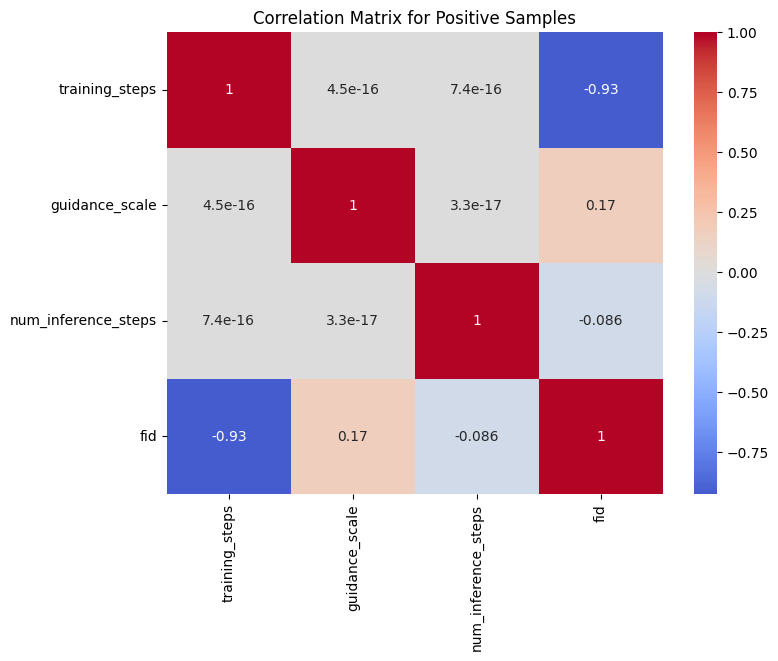

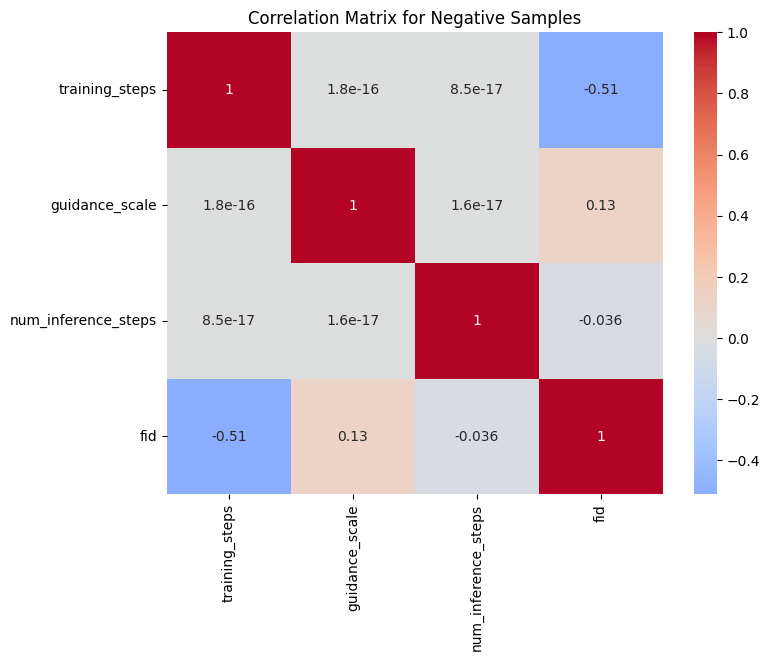

In [14]:
plot_correlation_heatmap(correlations_pos, "Correlation Matrix for Positive Samples")
plot_correlation_heatmap(correlations_neg, "Correlation Matrix for Negative Samples")

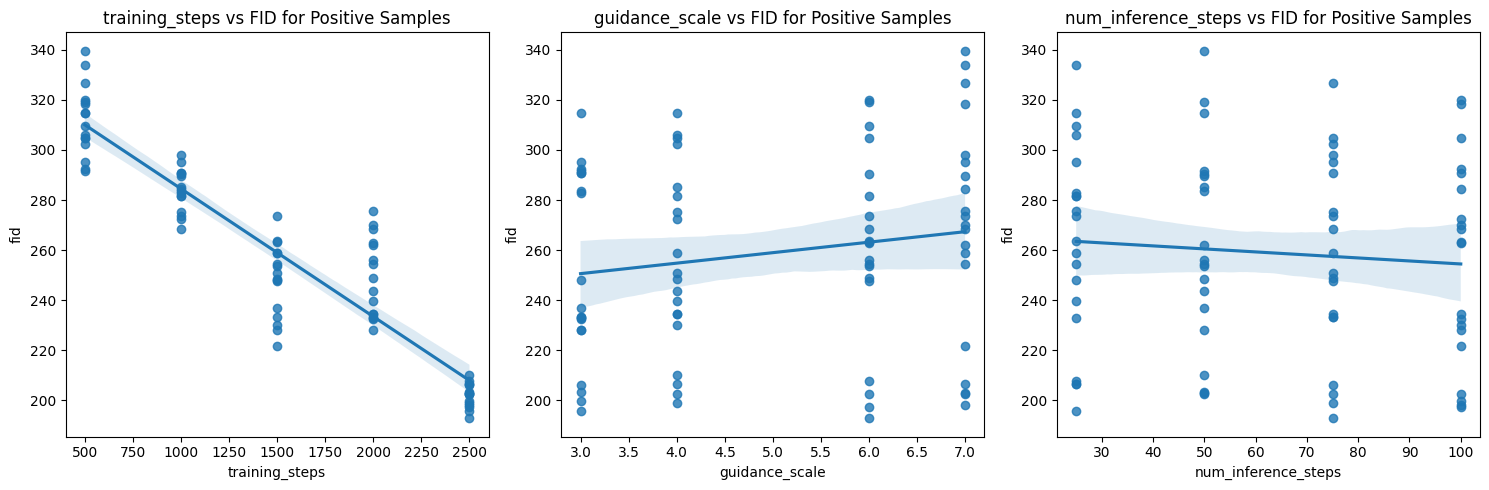

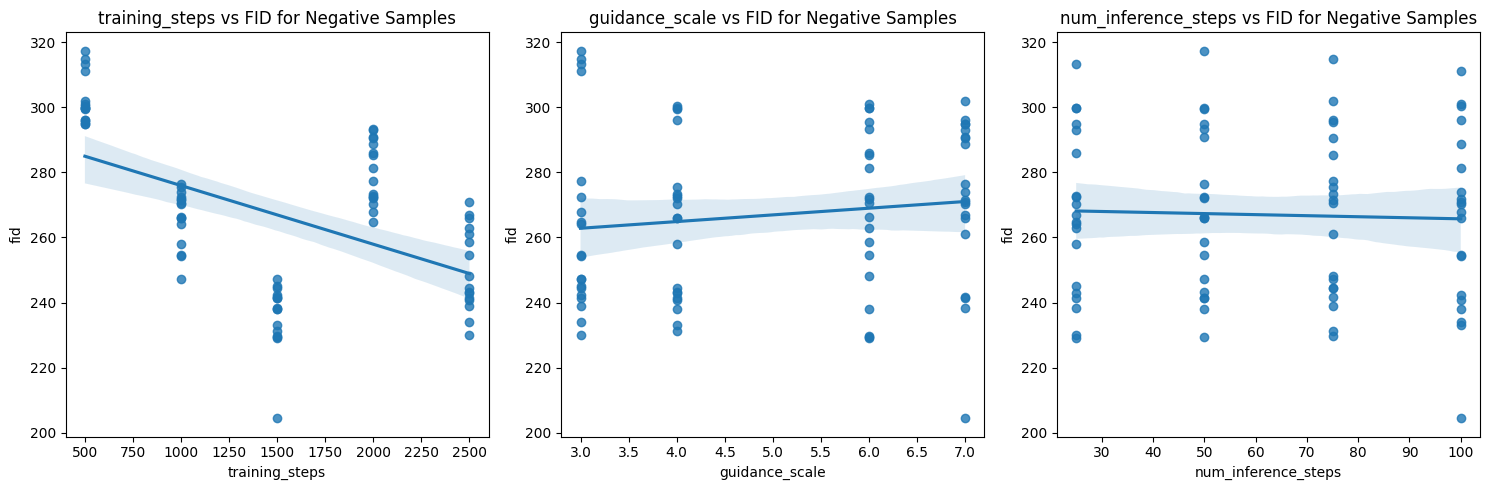

In [15]:
plot_all_regressions(positive_df, "Positive")
plot_all_regressions(negative_df, "Negative")

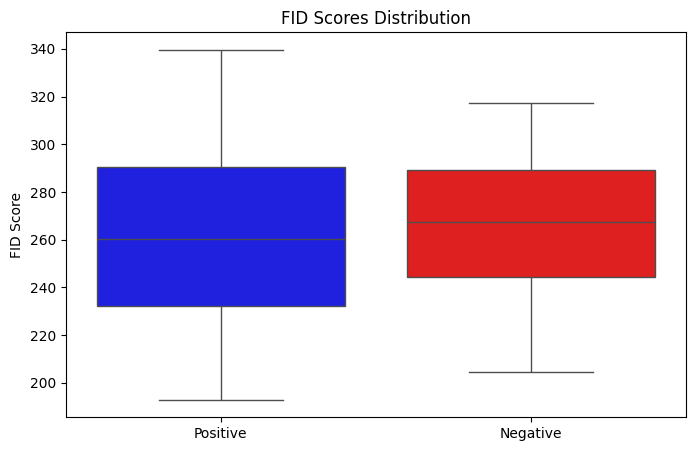

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame({'Positive': positive_df['fid'], 'Negative': negative_df['fid']}), palette=["blue", "red"])
plt.title("FID Scores Distribution")
plt.ylabel("FID Score")
plt.show()

In [17]:
# Convertiamo 'fid' in stringa e rimuoviamo gli zeri finali
positive_df['fid'] = positive_df['fid'].apply(lambda x: f"{x:.3f}".rstrip('0').rstrip('.'))
negative_df['fid'] = negative_df['fid'].apply(lambda x: f"{x:.3f}".rstrip('0').rstrip('.'))

# Salvataggio su CSV e TeX
positive_df.to_latex('/homes/obaldoni/bio_project/results_analysis/positive.tex', index=False)

negative_df.to_latex('/homes/obaldoni/bio_project/results_analysis/negative.tex', index=False)